# Лабораторная работа №11. Глазков Олег Игоревич

### Импорт библиотек

In [1]:
from typing import List, Tuple, Dict, Union
from pathlib import Path
import random

from tqdm import tqdm
from tqdm.notebook import tqdm
from IPython.display import clear_output

from PIL import Image
import numpy as np
import requests

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.models import MobileNet_V2_Weights, ResNet101_Weights, VGG19_Weights
from torchvision.transforms import v2
from torchinfo import summary

import matplotlib.pyplot as plt

import os
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
from typing import Tuple

### Определение класса обучения, валидации, сохранения, загрузки и отрисовки метрик

In [38]:
class MultilabelClassifierTrainer:
    """Класс для тренировки моделей"""
    def __init__(self,
            model: nn.Module,
            opt: torch.optim.Optimizer,
            loss_fn: nn.Module,
            scheduler: torch.optim.lr_scheduler.LRScheduler = None):

        self.model = model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        self.opt = opt
        self.scheduler = scheduler
        self.loss_fn = loss_fn

        self.init_log()

    def init_log(self) -> None:
        """Инициализация словаря для хранения значений ошибки и accuracy"""
        metrics_names = ('train_loss', 'val_loss', 'train_acc', 'val_acc')
        self.metrics = {key: [] for key in metrics_names}
        self.best_acc = 0

    @torch.inference_mode()
    def get_acc_from_logits(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Вычисляет accuracy из логитов"""
        preds = logits.argmax(dim=1) == targets
        return preds.sum()

    def train_batch(self, batch: Tuple[torch.Tensor, torch.Tensor], is_train: bool) -> Tuple[float, float]:
        """Вычисляет ошибку и accuracy по одному батчу"""
        inputs, targets = batch
        inputs, targets = inputs.to(self.device), targets.to(self.device)

        logits = self.model(inputs)
        batch_loss = self.loss_fn(logits, targets)
        batch_acc = self.get_acc_from_logits(logits, targets)

        if is_train:
            self.opt.zero_grad()
            batch_loss.backward()
            self.opt.step()

            if self.scheduler is not None:
                self.scheduler.step()

        return batch_loss.item(), batch_acc.item()

    def train_val_epoch(self, loader: DataLoader, is_train: bool) -> Tuple[float, float]:
        """Делает один проход по даталоадеру, и вычисляет ошибку и accuracy по всем данным"""
        epoch_loss, epoch_acc = 0, 0

        desc = 'Train' if is_train else 'Validation'
        self.model.train(is_train)

        with torch.inference_mode(not is_train):
            for batch in tqdm(loader, desc=desc, leave=False):
                batch_loss, batch_acc = self.train_batch(batch, is_train)
                epoch_loss += batch_loss
                epoch_acc += batch_acc

        return epoch_loss / len(loader), epoch_acc / len(loader.dataset)

    def train(self, epochs: int, train_loader: DataLoader, val_loader: DataLoader, best_checkpoint: str = '') -> str:
        """Производит тренировку модели и отрисовывает графики ошибок и accuracy. Сохраняет параметры модели и оптимизатора"""
        if best_checkpoint:
            self.load_checkpoint(best_checkpoint)

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = self.train_val_epoch(train_loader, is_train=True)
            self.metrics['train_loss'].append(train_loss)
            self.metrics['train_acc'].append(train_acc)

            val_loss, val_acc = self.train_val_epoch(val_loader, is_train=False)
            self.metrics['val_loss'].append(val_loss)
            self.metrics['val_acc'].append(val_acc)

            # сохранение весов если метрика выше чем self.best_acc
            if val_acc > self.best_acc:
                best_checkpoint = self.save_checkpoint()
                self.best_acc = val_acc

            clear_output(True)
            self.plot_metrics()

            print(f"Epoch {epoch}/{epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        return best_checkpoint

    def save_checkpoint(self) -> str:
        """Сохраняет параметры модели и оптимизатора"""
        checkpoint_path = "best_model.pth"
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.opt.state_dict(),
            'best_acc': self.best_acc,
        }, checkpoint_path)
        return checkpoint_path

    def load_checkpoint(self, checkpoint_path: str) -> None:
        """Загружает параметры модели и оптимизатора"""
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
        self.best_acc = checkpoint['best_acc']

    def plot_metrics(self) -> None:
        """Отрисовывает графики ошибок и точности"""
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.metrics['train_loss'], label='Train Loss')
        plt.plot(self.metrics['val_loss'], label='Val Loss')
        plt.title('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.metrics['train_acc'], label='Train Accuracy')
        plt.plot(self.metrics['val_acc'], label='Val Accuracy')
        plt.title('Accuracy')
        plt.legend()

        plt.show()

### Загрузка датасета - Люди в масках

In [3]:
# Инициализация API
api = KaggleApi()
api.authenticate()
# data = 'C:/Users/oigla/#Notebooks/data.lens/data.lens-1/datasets'
# api.dataset_download_files('ashishjangra27/face-mask-12k-images-dataset', path=data, unzip=True)

In [4]:
# Путь к локальному расположению каталога
DATASET_PATH = Path('C:/Users/oigla/#Notebooks/data.lens/data.lens-1/datasets/face-mask-detection/Face Mask Dataset')

In [5]:
# Какие форматы файлов в каждой из папок
np.unique([path.suffix for path in DATASET_PATH.glob('./*/*/*')])

array(['.png'], dtype='<U4')

### Список предобученных моделей Torchvision

In [7]:
# Список преобученных моделей из списка Torchvision
dir(torchvision.models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

### Архитектура MobileNet_V2

In [31]:
# Загрузка предобученных весов и аугментаций
weight = MobileNet_V2_Weights.IMAGENET1K_V2
weight_transforms = weight.transforms()

# Создание датасетов с применением аугментаций
train_dataset = ImageFolder(DATASET_PATH / 'Train', transform=weight_transforms)
valid_dataset = ImageFolder(DATASET_PATH / 'Validation', transform=weight_transforms)
test_dataset = ImageFolder(DATASET_PATH / 'Test', transform=weight_transforms)

# Соединение датасетов для валидации и тестирования в один датасет
val_dataset = ConcatDataset([valid_dataset, test_dataset])

# Подсчет количества изображений в каждом датасете
num_train_images = len(train_dataset)
num_val_images = len(val_dataset)

print(f"Количество изображений в обучающем датасете: {num_train_images}")
print(f"Количество изображений в валидационном датасете: {num_val_images}")

Количество изображений в обучающем датасете: 10000
Количество изображений в валидационном датасете: 1792


In [32]:
# Аугментации на которых обучалась модель
weight_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

#### Просмотр распределения классов

In [33]:
# Преобразуем словарь из индексов в классы
index_to_class = {value: key for key, value in train_dataset.class_to_idx.items()}
index_to_class

{0: 'WithMask', 1: 'WithoutMask'}

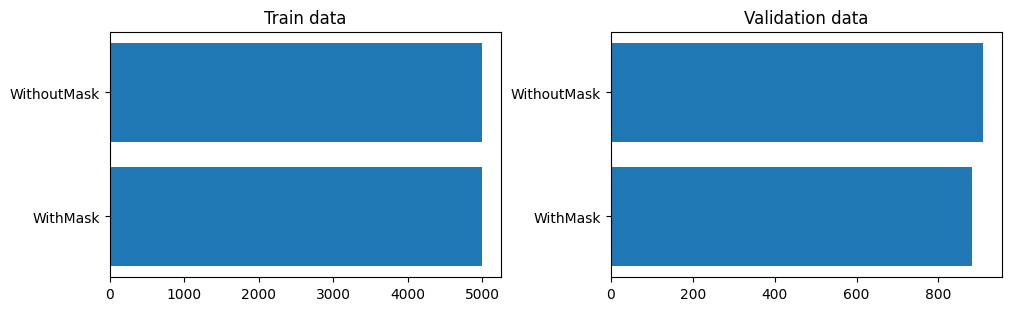

In [34]:
# посмотреть на распределение классов в каждом наборе данных
train_targets = torch.tensor(train_dataset.targets)

# взять таргеты из датасетов val и test которые мы объединили в один
val_targets = np.concatenate([dataset.targets for dataset in val_dataset.datasets])

# индексы классов для оси икс
classes_list = list(index_to_class.values())

# отрисовать сколько какого класса в каждом наборе данных
fig, axes = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
axes[0].set_title('Train data')
axes[0].barh(classes_list, train_targets.bincount())
axes[1].set_title('Validation data')
axes[1].barh(classes_list, np.bincount(val_targets))
plt.show()

#### Просмотр изображений

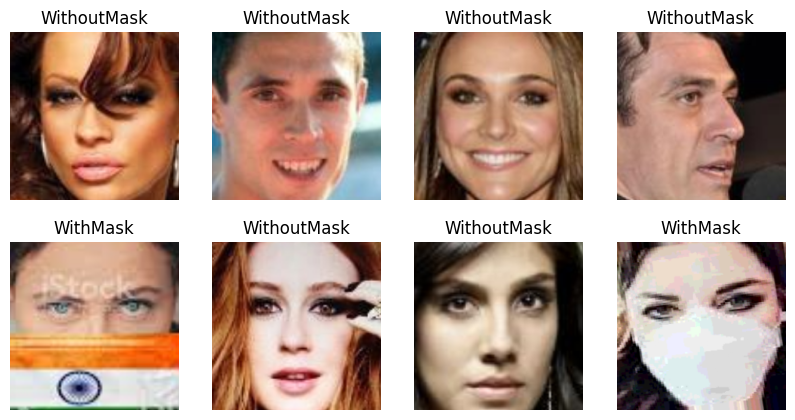

In [36]:
torch.manual_seed(42)

# берем случайные индексы для отрисовки
indexes = torch.randint(len(train_dataset), size=(8,))

# получим тензора картинок из датасета по индексам
images = [train_dataset[indx][0] for indx in indexes]

# получим их индексы классов
class_indexes = [train_dataset[indx][1] for indx in indexes]

# создать графики 2 на 4
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

# итерация по картинкам, индексам и графикам
for image, class_indx, ax in zip(images, class_indexes, axes.ravel()):
    # название графика
    ax.set_title(index_to_class[class_indx])
    # обратная нормировка (inverse transform) для правильной отрисовки - умножить на std и прибавить среднее
    image = image * torch.tensor(weight_transforms.std)[:, None, None] + torch.tensor(weight_transforms.mean)[:, None, None]
    # отрисовать картинку
    ax.imshow(image.permute(1, 2, 0))
    ax.axis('off')

plt.show()

In [45]:
# Задание размера батча
BATCH_SIZE = 64

# Создание DataLoader для обучающего и валидационного датасетов
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# Получение одного батча из DataLoader для проверки
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

# Количество объектов в одном батче
num_train_objects_in_batch = len(train_batch[0])
num_val_objects_in_batch = len(val_batch[0])

print(f"Количество объектов в одном батче обучающего набора: {num_train_objects_in_batch}")
print(f"Количество объектов в одном батче валидационного набора: {num_val_objects_in_batch}")

Количество объектов в одном батче обучающего набора: 64
Количество объектов в одном батче валидационного набора: 64


In [40]:
# Иициализация модели
model = torchvision.models.mobilenet_v2(weights=weight)

In [41]:
# кол-во всех параметров модели
num_params = sum(param.numel() for param in model.parameters())
f'{num_params:,}'

'3,504,872'

In [42]:
# кол-во обучаемых матриц весов
len_trainable_params = sum(param.requires_grad for param in model.parameters())
len_trainable_params

158

In [43]:
# заморозка весов
for param in model.parameters():
    param.requires_grad = False

# замена выходного слоя классификатора на новый
in_size, out_size = model.classifier[1].in_features, len(train_dataset.class_to_idx)
model.classifier[1] = nn.Linear(in_size, out_size)

# параметры нужного слоя будем складывать в список, и включать у них градиенты
params18 = []
for param in model.features[18].parameters():
    param.requires_grad = True
    params18.append(param)

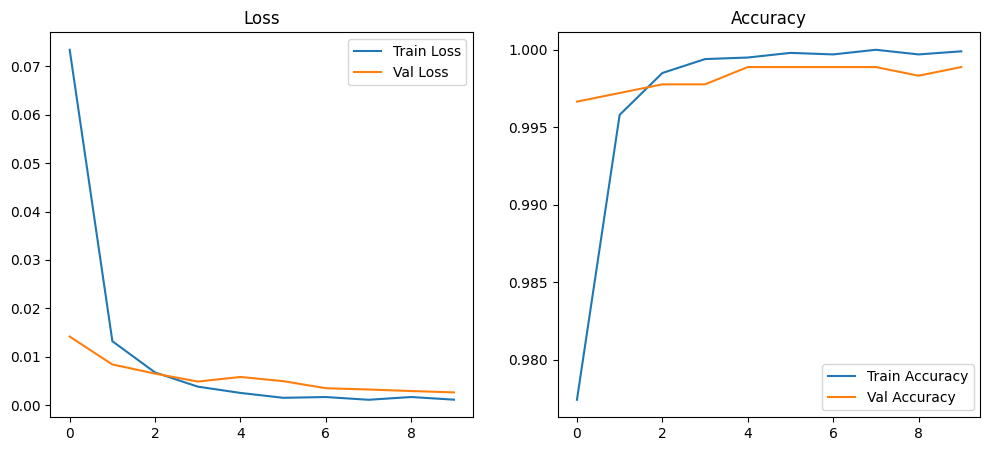

Epoch 10/10
Train Loss: 0.0011, Train Acc: 0.9999
Val Loss: 0.0026, Val Acc: 0.9989
CPU times: total: 36min 46s
Wall time: 6min 20s


In [44]:
%%time

opt = torch.optim.Adam([
    {'params': model.classifier[1].parameters(), 'lr': 0.001},
    {'params': params18, 'lr': 0.0005},
    ])

# функция ошибки
loss_fn = nn.CrossEntropyLoss()

# объект тренера
trainer = MultilabelClassifierTrainer(model, opt, loss_fn)

# обучение EPOCHS эпох
EPOCHS = 10
best_checkpoint = trainer.train(EPOCHS, train_loader, val_loader)

### Архитектура ResNet101

In [57]:
class MultilabelClassifierTrainer:
    """Класс для тренировки моделей"""
    def __init__(self,
            model_resnet101: nn.Module,
            opt: torch.optim.Optimizer,
            loss_fn: nn.Module,
            scheduler: torch.optim.lr_scheduler.LRScheduler = None):

        self.model_resnet101 = model_resnet101
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model_resnet101.to(self.device)

        self.opt = opt
        self.scheduler = scheduler
        self.loss_fn = loss_fn

        self.init_log()

    def init_log(self) -> None:
        """Инициализация словаря для хранения значений ошибки и accuracy"""
        metrics_names = ('train_loss', 'val_loss', 'train_acc', 'val_acc')
        self.metrics = {key: [] for key in metrics_names}
        self.best_acc = 0

    @torch.inference_mode()
    def get_acc_from_logits(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Вычисляет accuracy из логитов"""
        preds = logits.argmax(dim=1) == targets
        return preds.sum()

    def train_batch(self, batch: Tuple[torch.Tensor, torch.Tensor], is_train: bool) -> Tuple[float, float]:
        """Вычисляет ошибку и accuracy по одному батчу"""
        inputs, targets = batch
        inputs, targets = inputs.to(self.device), targets.to(self.device)

        logits = self.model_resnet101(inputs)
        batch_loss = self.loss_fn(logits, targets)
        batch_acc = self.get_acc_from_logits(logits, targets)

        if is_train:
            self.opt.zero_grad()
            batch_loss.backward()
            self.opt.step()

            if self.scheduler is not None:
                self.scheduler.step()

        return batch_loss.item(), batch_acc.item()

    def train_val_epoch(self, loader: DataLoader, is_train: bool) -> Tuple[float, float]:
        """Делает один проход по даталоадеру, и вычисляет ошибку и accuracy по всем данным"""
        epoch_loss, epoch_acc = 0, 0

        desc = 'Train' if is_train else 'Validation'
        self.model_resnet101.train(is_train)

        with torch.inference_mode(not is_train):
            for batch in tqdm(loader, desc=desc, leave=False):
                batch_loss, batch_acc = self.train_batch(batch, is_train)
                epoch_loss += batch_loss
                epoch_acc += batch_acc

        return epoch_loss / len(loader), epoch_acc / len(loader.dataset)

    def train(self, epochs: int, train_loader: DataLoader, val_loader: DataLoader, best_checkpoint: str = '') -> str:
        """Производит тренировку модели и отрисовывает графики ошибок и accuracy. Сохраняет параметры модели и оптимизатора"""
        if best_checkpoint:
            self.load_checkpoint(best_checkpoint)

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = self.train_val_epoch(train_loader, is_train=True)
            self.metrics['train_loss'].append(train_loss)
            self.metrics['train_acc'].append(train_acc)

            val_loss, val_acc = self.train_val_epoch(val_loader, is_train=False)
            self.metrics['val_loss'].append(val_loss)
            self.metrics['val_acc'].append(val_acc)

            # сохранение весов если метрика выше чем self.best_acc
            if val_acc > self.best_acc:
                best_checkpoint = self.save_checkpoint()
                self.best_acc = val_acc

            clear_output(True)
            self.plot_metrics()

            print(f"Epoch {epoch}/{epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        return best_checkpoint

    def save_checkpoint(self) -> str:
        """Сохраняет параметры модели и оптимизатора"""
        checkpoint_path = "best_model.pth"
        torch.save({
            'model_state_dict': self.model_resnet101.state_dict(),
            'optimizer_state_dict': self.opt.state_dict(),
            'best_acc': self.best_acc,
        }, checkpoint_path)
        return checkpoint_path

    def load_checkpoint(self, checkpoint_path: str) -> None:
        """Загружает параметры модели и оптимизатора"""
        checkpoint = torch.load(checkpoint_path)
        self.model_resnet101.load_state_dict(checkpoint['model_state_dict'])
        self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
        self.best_acc = checkpoint['best_acc']

    def plot_metrics(self) -> None:
        """Отрисовывает графики ошибок и точности"""
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.metrics['train_loss'], label='Train Loss')
        plt.plot(self.metrics['val_loss'], label='Val Loss')
        plt.title('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.metrics['train_acc'], label='Train Accuracy')
        plt.plot(self.metrics['val_acc'], label='Val Accuracy')
        plt.title('Accuracy')
        plt.legend()

        plt.show()

In [47]:
# Загрузка предобученных весов и аугментаций
weight = ResNet101_Weights.DEFAULT
weight_transforms = weight.transforms()

# Создание датасетов с применением аугментаций
train_dataset = ImageFolder(DATASET_PATH / 'Train', transform=weight_transforms)
valid_dataset = ImageFolder(DATASET_PATH / 'Validation', transform=weight_transforms)
test_dataset = ImageFolder(DATASET_PATH / 'Test', transform=weight_transforms)

# Соединение датасетов для валидации и тестирования в один датасет
val_dataset = ConcatDataset([valid_dataset, test_dataset])

# Подсчет количества изображений в каждом датасете
num_train_images = len(train_dataset)
num_val_images = len(val_dataset)

print(f"Количество изображений в обучающем датасете: {num_train_images}")
print(f"Количество изображений в валидационном датасете: {num_val_images}")

Количество изображений в обучающем датасете: 10000
Количество изображений в валидационном датасете: 1792


In [48]:
# Задание размера батча
BATCH_SIZE = 64

# Создание DataLoader для обучающего и валидационного датасетов
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# Получение одного батча из DataLoader для проверки
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

# Количество объектов в одном батче
num_train_objects_in_batch = len(train_batch[0])
num_val_objects_in_batch = len(val_batch[0])

print(f"Количество объектов в одном батче обучающего набора: {num_train_objects_in_batch}")
print(f"Количество объектов в одном батче валидационного набора: {num_val_objects_in_batch}")

Количество объектов в одном батче обучающего набора: 64
Количество объектов в одном батче валидационного набора: 64


In [49]:
# Загрузка модели с предобученными весами
model_resnet101 = torchvision.models.resnet101(weights=weight)

In [50]:
# Подсчет общего количества параметров в модели
num_params = sum(param.numel() for param in model_resnet101.parameters())

# Форматирование строки с разделителем для тысяч
formatted_num_params = f'{num_params:,}'
print(formatted_num_params)

44,549,160


In [51]:
len_trainable_params = sum(param.requires_grad for param in model_resnet101.parameters())
print("Изначальное количество обучаемых параметров:", len_trainable_params)

Изначальное количество обучаемых параметров: 314


In [52]:
# отключить градиенты у всех весов модели
model_resnet101.requires_grad_(False)

len_trainable_params_after_freeze = sum(param.requires_grad for param in model_resnet101.parameters())
print("Количество обучаемых параметров после отключения градиентов:", len_trainable_params_after_freeze)

Количество обучаемых параметров после отключения градиентов: 0


In [53]:
# 1000 нейронов для 1000 классов датасета ImageNet
model_resnet101.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [54]:
in_size, out_size = model_resnet101.fc.in_features, len(train_dataset.classes)
model_resnet101.fc = nn.Linear(in_size, out_size)
print("Новый слой fc:", model_resnet101.fc)

Новый слой fc: Linear(in_features=2048, out_features=2, bias=True)


In [55]:
len_trainable_params_after_replacement = sum(param.requires_grad for param in model_resnet101.parameters())
print("Количество обучаемых параметров после замены слоя:", len_trainable_params_after_replacement)

Количество обучаемых параметров после замены слоя: 2


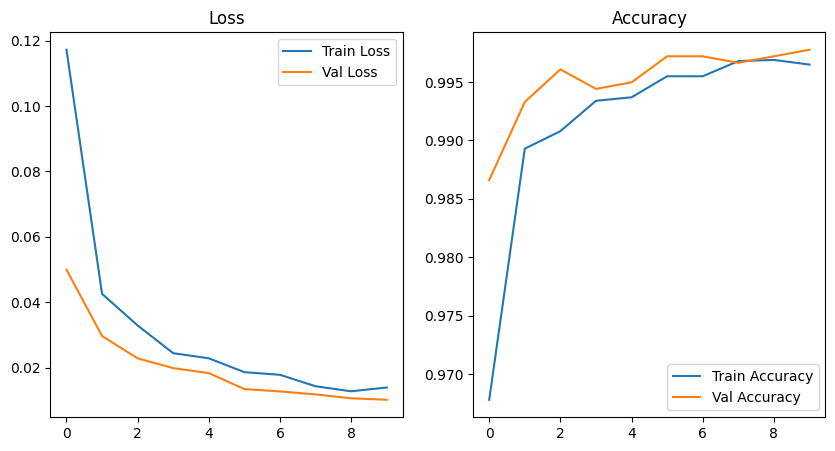

Epoch 10/10
Train Loss: 0.0139, Train Acc: 0.9965
Val Loss: 0.0102, Val Acc: 0.9978
CPU times: total: 47min 20s
Wall time: 12min 4s


In [58]:
%%time
# Определение функции потерь и оптимизатора
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_resnet101.fc.parameters())

# Объект тренера
trainer = MultilabelClassifierTrainer(model_resnet101, opt, loss_fn)

# Обучение модели
EPOCHS = 10
best_checkpoint = trainer.train(EPOCHS, train_loader, val_loader)

### Архитектура VGG19

In [59]:
class MultilabelClassifierTrainer:
    """Класс для тренировки моделей"""
    def __init__(self,
            model_vgg19: nn.Module,
            opt: torch.optim.Optimizer,
            loss_fn: nn.Module,
            scheduler: torch.optim.lr_scheduler.LRScheduler = None):

        self.model_vgg19 = model_vgg19
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model_vgg19.to(self.device)

        self.opt = opt
        self.scheduler = scheduler
        self.loss_fn = loss_fn

        self.init_log()

    def init_log(self) -> None:
        """Инициализация словаря для хранения значений ошибки и accuracy"""
        metrics_names = ('train_loss', 'val_loss', 'train_acc', 'val_acc')
        self.metrics = {key: [] for key in metrics_names}
        self.best_acc = 0

    @torch.inference_mode()
    def get_acc_from_logits(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Вычисляет accuracy из логитов"""
        preds = logits.argmax(dim=1) == targets
        return preds.sum()

    def train_batch(self, batch: Tuple[torch.Tensor, torch.Tensor], is_train: bool) -> Tuple[float, float]:
        """Вычисляет ошибку и accuracy по одному батчу"""
        inputs, targets = batch
        inputs, targets = inputs.to(self.device), targets.to(self.device)

        logits = self.model_vgg19(inputs)
        batch_loss = self.loss_fn(logits, targets)
        batch_acc = self.get_acc_from_logits(logits, targets)

        if is_train:
            self.opt.zero_grad()
            batch_loss.backward()
            self.opt.step()

            if self.scheduler is not None:
                self.scheduler.step()

        return batch_loss.item(), batch_acc.item()

    def train_val_epoch(self, loader: DataLoader, is_train: bool) -> Tuple[float, float]:
        """Делает один проход по даталоадеру, и вычисляет ошибку и accuracy по всем данным"""
        epoch_loss, epoch_acc = 0, 0

        desc = 'Train' if is_train else 'Validation'
        self.model_vgg19.train(is_train)

        with torch.inference_mode(not is_train):
            for batch in tqdm(loader, desc=desc, leave=False):
                batch_loss, batch_acc = self.train_batch(batch, is_train)
                epoch_loss += batch_loss
                epoch_acc += batch_acc

        return epoch_loss / len(loader), epoch_acc / len(loader.dataset)

    def train(self, epochs: int, train_loader: DataLoader, val_loader: DataLoader, best_checkpoint: str = '') -> str:
        """Производит тренировку модели и отрисовывает графики ошибок и accuracy. Сохраняет параметры модели и оптимизатора"""
        if best_checkpoint:
            self.load_checkpoint(best_checkpoint)

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = self.train_val_epoch(train_loader, is_train=True)
            self.metrics['train_loss'].append(train_loss)
            self.metrics['train_acc'].append(train_acc)

            val_loss, val_acc = self.train_val_epoch(val_loader, is_train=False)
            self.metrics['val_loss'].append(val_loss)
            self.metrics['val_acc'].append(val_acc)

            # сохранение весов если метрика выше чем self.best_acc
            if val_acc > self.best_acc:
                best_checkpoint = self.save_checkpoint()
                self.best_acc = val_acc

            clear_output(True)
            self.plot_metrics()

            print(f"Epoch {epoch}/{epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        return best_checkpoint

    def save_checkpoint(self) -> str:
        """Сохраняет параметры модели и оптимизатора"""
        checkpoint_path = "best_model.pth"
        torch.save({
            'model_state_dict': self.model_vgg19.state_dict(),
            'optimizer_state_dict': self.opt.state_dict(),
            'best_acc': self.best_acc,
        }, checkpoint_path)
        return checkpoint_path

    def load_checkpoint(self, checkpoint_path: str) -> None:
        """Загружает параметры модели и оптимизатора"""
        checkpoint = torch.load(checkpoint_path)
        self.model_vgg19.load_state_dict(checkpoint['model_state_dict'])
        self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
        self.best_acc = checkpoint['best_acc']

    def plot_metrics(self) -> None:
        """Отрисовывает графики ошибок и точности"""
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.metrics['train_loss'], label='Train Loss')
        plt.plot(self.metrics['val_loss'], label='Val Loss')
        plt.title('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.metrics['train_acc'], label='Train Accuracy')
        plt.plot(self.metrics['val_acc'], label='Val Accuracy')
        plt.title('Accuracy')
        plt.legend()

        plt.show()

In [60]:
# Загрузка предобученных весов и аугментаций
weight = VGG19_Weights.DEFAULT
weight_transforms = weight.transforms()

# Создание датасетов с применением аугментаций
train_dataset = ImageFolder(DATASET_PATH / 'Train', transform=weight_transforms)
valid_dataset = ImageFolder(DATASET_PATH / 'Validation', transform=weight_transforms)
test_dataset = ImageFolder(DATASET_PATH / 'Test', transform=weight_transforms)

# Соединение датасетов для валидации и тестирования в один датасет
val_dataset = ConcatDataset([valid_dataset, test_dataset])

# Подсчет количества изображений в каждом датасете
num_train_images = len(train_dataset)
num_val_images = len(val_dataset)

print(f"Количество изображений в обучающем датасете: {num_train_images}")
print(f"Количество изображений в валидационном датасете: {num_val_images}")

Количество изображений в обучающем датасете: 10000
Количество изображений в валидационном датасете: 1792


In [61]:
# Задание размера батча
BATCH_SIZE = 64

# Создание DataLoader для обучающего и валидационного датасетов
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# Получение одного батча из DataLoader для проверки
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

# Количество объектов в одном батче
num_train_objects_in_batch = len(train_batch[0])
num_val_objects_in_batch = len(val_batch[0])

print(f"Количество объектов в одном батче обучающего набора: {num_train_objects_in_batch}")
print(f"Количество объектов в одном батче валидационного набора: {num_val_objects_in_batch}")

Количество объектов в одном батче обучающего набора: 64
Количество объектов в одном батче валидационного набора: 64


In [62]:
# указываем строку название модели
model_vgg19 = torchvision.models.vgg19(weights=weight)

In [63]:
summary(model_vgg19,input_size=(1, 3, 100, 100), depth=5)

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 3, 3]            --
│    └─Conv2d: 2-1                       [1, 64, 100, 100]         1,792
│    └─ReLU: 2-2                         [1, 64, 100, 100]         --
│    └─Conv2d: 2-3                       [1, 64, 100, 100]         36,928
│    └─ReLU: 2-4                         [1, 64, 100, 100]         --
│    └─MaxPool2d: 2-5                    [1, 64, 50, 50]           --
│    └─Conv2d: 2-6                       [1, 128, 50, 50]          73,856
│    └─ReLU: 2-7                         [1, 128, 50, 50]          --
│    └─Conv2d: 2-8                       [1, 128, 50, 50]          147,584
│    └─ReLU: 2-9                         [1, 128, 50, 50]          --
│    └─MaxPool2d: 2-10                   [1, 128, 25, 25]          --
│    └─Conv2d: 2-11                      [1, 256, 25, 25]          29

In [64]:
len_trainable_params = sum(param.requires_grad for param in model_vgg19.parameters())
print("Изначальное количество обучаемых параметров:", len_trainable_params)

Изначальное количество обучаемых параметров: 38


In [65]:
# отключить градиенты у всех весов модели
model_vgg19.requires_grad_(False)

len_trainable_params_after_freeze = sum(param.requires_grad for param in model_vgg19.parameters())
print("Количество обучаемых параметров после отключения градиентов:", len_trainable_params_after_freeze)

Количество обучаемых параметров после отключения градиентов: 0


In [ ]:
model_vgg19.classifier[-1]

In [66]:
in_size, out_size = model_vgg19.classifier[-1].in_features, len(train_dataset.classes)
model_vgg19.classifier[-1] = nn.Linear(in_size, out_size)
print("Новый слой fc:", model_vgg19.classifier[-1])

Новый слой fc: Linear(in_features=4096, out_features=2, bias=True)


In [67]:
len_trainable_params_after_replacement = sum(param.requires_grad for param in model_vgg19.parameters())
print("Количество обучаемых параметров после замены слоя:", len_trainable_params_after_replacement)

Количество обучаемых параметров после замены слоя: 2


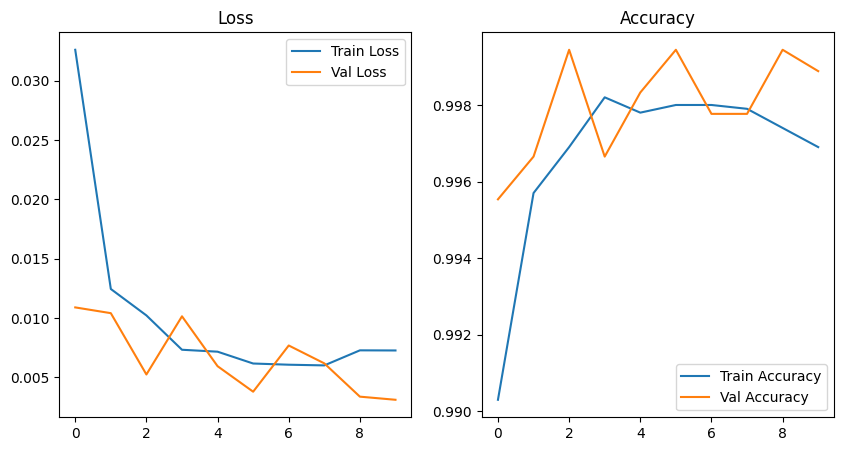

Epoch 10/10
Train Loss: 0.0073, Train Acc: 0.9969
Val Loss: 0.0031, Val Acc: 0.9989
CPU times: total: 51min 3s
Wall time: 14min 54s


In [68]:
%%time
# функция ошибки
loss_fn = nn.CrossEntropyLoss()

# передаем в оптимизатор последний слой который мы добавили - у него включены градиенты чтобы обучаться
# если мы передадим параметры всей сети то будет тоже самое потому что градиенты мы отключили
opt = torch.optim.Adam(model_vgg19.classifier[-1].parameters())

# объект тренера
trainer = MultilabelClassifierTrainer(model_vgg19, opt, loss_fn)

# обучение EPOCHS эпох
EPOCHS = 10
best_checkpoint = trainer.train(EPOCHS, train_loader, val_loader)

In [69]:
model_vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd